# `dIdV.ipynb`

Notebook for dIdV study fits

- didv notes:
- square wave
- 100 Hz
- 20 mV
- gain 50
- offx - QET bias in V
- Sig Gen

In [1]:
# imports
import sys
import os
import pickle
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import scipy.stats as st


# custom modules
from picoscopedata import PicoscopeData
from utilities import *


find_imports()
import qetpy as qp
import optimal_filter_utils as of


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
# read in results from IbIs analysis
runnum = 5
ibis_runname = '20250605-0006'
runname = '20250605-0003'
#folder_base = '/Users/ajbiffl/Documents/CDMS/oxford_fridge'
folder_base = 'C:/Users/MINER/Documents/B13 Cryolab'

with open(folder_base + f'/Run{runnum}/IbIs Data/{ibis_runname}_results.dat', 'rb') as f:
    ibis, ivfits, tr_fits = pickle.load(f)

In [4]:
import importlib
import picoscopedata
importlib.reload(picoscopedata)
from picoscopedata import PicoscopeData

# config dict
drive_path = folder_base + f'/Run{runnum}/dIdV Data'
channels = 'BCD'
glob_pattern = drive_path + '/' + runname + '*' + '/*.csv'
print(glob_pattern)

#didv = PicoscopeData(runname, drive_path, idx = range(64*10), vertical_stack = True, glob_pattern = glob_pattern, row_avg = 1, throw_nans = True)
# single file
didv = PicoscopeData(runname, drive_path, glob_pattern = glob_pattern, row_avg = 1, throw_nans = True)

C:/Users/MINER/Documents/B13 Cryolab/Run5/dIdV Data/20250605-0003*/*.csv
Created new PicoscopeData object with 10000004 data points
Channels: ['B', 'C', 'D', 'H']


In [5]:
if 1:
    features = ["ds", "DSB", "DSstd", "bs", "dp1", "dp2", "slope_left", "slope_right"]

    all_ch_features = {ch: {f: [] for f in features} for ch in channels}

    x_left = [2500 + i * 10_000 for i in range(10)]
    x_right = [7500 + i * 10_000 for i in range(10)]
    for i in range(64*16):
        df = pd.read_csv(didv.trace_file(i), skiprows = (1,2), na_values = ["∞", "-∞"])
        for ch in channels:
            trace = df['Channel ' + ch].values
            sa = trace[2500]
            sb = trace[7500]
            s1, s2 = sorted((sa, sb))
            p2 = trace[:7500].max()
            p1 = trace[:7500].min()

            SA = trace[x_left]
            SB = trace[x_right]

            DSB = np.mean(np.abs(SB - SA))
            DSstd = np.std(SB - SA)

            slope_left = np.polyfit(x_left, SA, 1)[0]
            slope_right = np.polyfit(x_right, SB, 1)[0]

            all_ch_features[ch]["ds"].append(s2 - s1)
            all_ch_features[ch]["DSB"].append(DSB)
            all_ch_features[ch]["DSstd"].append(DSstd)
            all_ch_features[ch]["bs"].append((s1+s2)/2)
            all_ch_features[ch]["dp1"].append(s1 - p1)
            all_ch_features[ch]["dp2"].append(p2 - s2)
            all_ch_features[ch]["slope_left"].append(slope_left)
            all_ch_features[ch]["slope_right"].append(slope_right)
    for ch in channels:
        all_ch_features[ch] = pd.DataFrame(all_ch_features[ch])

In [6]:
all_ch_features_cut = {ch: pd.DataFrame() for ch in channels}

all_ch_features_cut['A'] = all_ch_features['A'].loc[(all_ch_features['A']['ds'] > 0.55) * (abs(all_ch_features['A']['slope_right']) < 2.5e-6)]

all_ch_features_cut['B'] = all_ch_features['B'].loc[(all_ch_features['B']['ds'] < 3) * (abs(all_ch_features['B']['bs']) < 0.1) * (abs(all_ch_features['B']['slope_right']) < 2e-6)]

all_ch_features_cut['C'] = all_ch_features['C'].loc[(all_ch_features['C']['ds'] > 0.25) * (abs(all_ch_features['C']['slope_right']) < 2.5e-6)]

all_ch_features_cut['D'] = all_ch_features['D'].loc[(all_ch_features['D']['ds'] > 2.5) * (abs(all_ch_features['D']['slope_right']) < 5e-6)]

for ch in channels:
    print(f"Ch {ch}: {len(all_ch_features_cut[ch]) / 16}")

Ch A: 8.1875
Ch B: 9.5
Ch C: 9.5
Ch D: 29.4375


In [7]:
after_cuts = True
if after_cuts:
    df = all_ch_features_cut
else:
    df = all_ch_features

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['ds']), bins = 100, histtype = 'step', label = 'ds')
    ax.set_title(c)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['DSB']), bins = 100, histtype = 'step', label = 'DSB')
    ax.hist(np.array(df[c]['DSstd']), bins = 100, histtype = 'step', label = 'DSstd')
    ax.set_title(c)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['bs']), bins = 100, histtype = 'step', label = 'bs')
    ax.set_title(c)
    ax.set_xlim(-1,1)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['dp2']), bins = 100, histtype = 'step', label = 'dp2')
    ax.hist(np.array(df[c]['dp1']), bins = 100, histtype = 'step', label = 'dp1')
    ax.set_title(c)
    ax.grid()
    ax.legend()

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))
for c, ax in zip('ABCD', axs.flatten()):
    ax.hist(np.array(df[c]['slope_right']), bins = 100, histtype = 'step', label = 'slope_right')
    ax.hist(np.array(df[c]['slope_left']), bins = 100, histtype = 'step', label = 'slope_left')
    ax.set_title(c)
    # ax.set_xlim(-,1)
    ax.grid()
    ax.legend()

NameError: name 'all_ch_features_cut' is not defined

In [5]:
for c in didv.channels:
    print(c, didv(c).shape)

B (10000004,)
C (10000004,)
D (10000004,)
H (10000004,)


In [6]:
# convert didv.arrs to ADC (Amps):
for chan in channels:
    didv.arrs[chan] = didv.arrs[chan][:,:100000]
didv.resize(0,100_000)

AttributeError: 'PicoscopeData' object has no attribute 'arrs'

In [19]:
c = 'B'
x = didv.arrs[c]
I,J = x.shape
for i in range(I):
    if any(np.isnan(x[i])):
        print(i)

AttributeError: 'PicoscopeData' object has no attribute 'arrs'

In [8]:
didv('B').shape

(10000004,)

In [9]:
R_ops = tr_fits.loc['R_op'].values
R_ops*1e3 # milliohms

array([ 8.84132526, 40.19907855, 33.31875031])

In [10]:
B_avg = didv('B').mean(axis=0)
any(np.isnan(B_avg))

TypeError: 'numpy.bool' object is not iterable

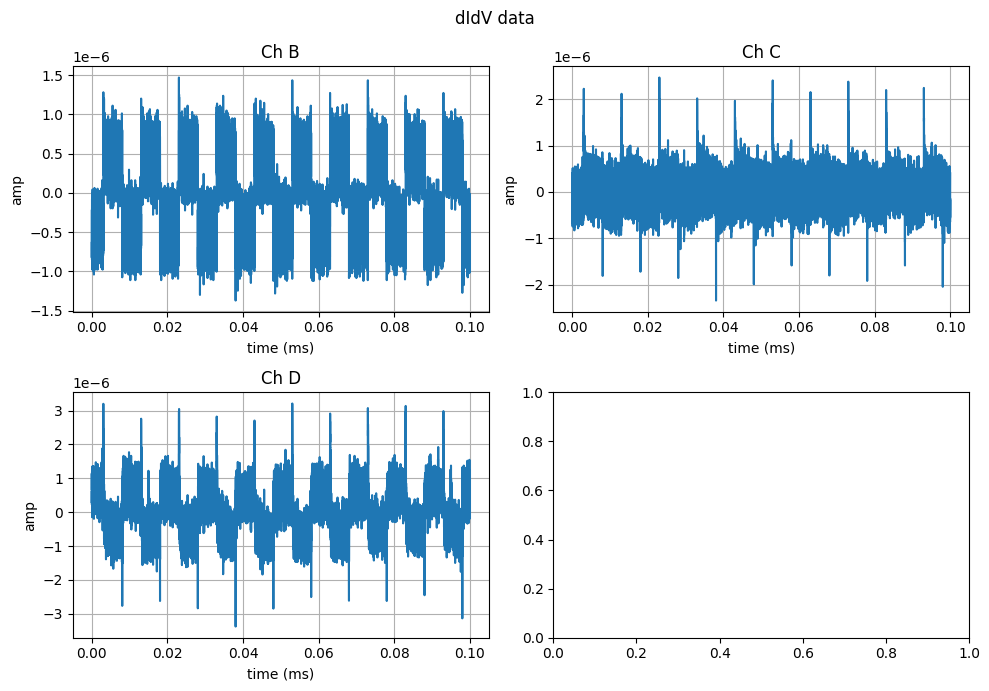

In [228]:
# plot DIDV data
numrows = (1+len(channels))//2

didv_waveform = didv('H')

fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):

    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    #ax.plot(didv.ts*1e3, didv(c)[5])
    #ax.plot(didv.ts*1e3, didv('H')/10, alpha = 0.2)
    # for i in range(10):
    #     ax.axvline(didv.ts[2500 + i*10_000]*1e3)
    #     ax.axvline(didv.ts[7500 + i*10_000]*1e3)
    #ax.plot(didv.ts*1e3, didv(c).mean(axis=0))
    ax.plot(didv.ts[:100_000]*1e3, didv(c)[:100_000])
    #ax.set_ylim(-1e-6, 1e-6)
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


In [244]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offB': -189.0,
 'offC': -129.4,
 'offD': -89.4}

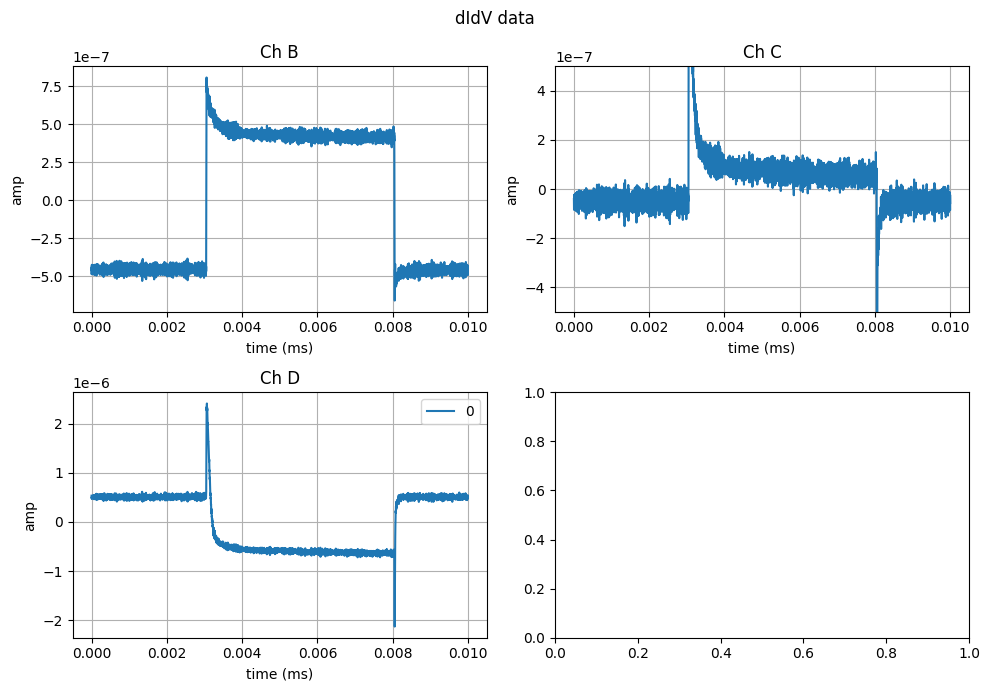

In [227]:
# plot DIDV data
numrows = (1+len(channels))//2


fig, axs = plt.subplots(nrows = numrows, ncols = 2, figsize = (10,3.5*numrows))

fig.suptitle('dIdV data')


for i, (c, ax) in enumerate(zip(channels, axs.flatten())):
    ax.grid()
    ax.set_ylabel('amp')
    ax.set_xlabel('time (ms)')
    ax.set_title(f'Ch {c}')

    #data_arr = didv(c)
    #tvals = didv.ts
    Nrow = 10_000
    tvals = didv.ts[:Nrow]

    for j in range(1):
        data_arr = np.reshape(didv(c)[:-4], (-1, Nrow))[100*j:100*(j+1)]
            
        if 0:
            for t in data_arr:
                ax.plot(tvals*1e3, t, alpha = 0.05, color = 'C0')
        ax.plot(tvals*1e3, data_arr.mean(axis=0), label = j)

    if c == 'D':
        pass
        ax.legend()
    elif c == 'C':
        ax.set_ylim(-5e-7, 5e-7)

    #data_arr -= np.expand_dims(data_arr.mean(axis = 1), 1)

    
    #ax.plot(tvals*1e3, didv('H')/10, alpha = 0.2)
    #ax.axvline(tvals[7500]*1e3)
    #ax.set_ylim(-2e-6*(2 if c == 'D' else 1), 2e-6*(2 if c == 'D' else 1))
    #ax.plot(didv1.ts*1e3, didv1(c))

fig.tight_layout()


In [23]:
ff = np.round(1/((np.diff(didv.ts)).mean()))
freq = 100

ff, freq, ff/freq, didv.ts.size/10

(np.float64(1000000003.0), 100, np.float64(10000000.03), 1000000.4)

In [24]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offB': -189.0,
 'offC': -129.4,
 'offD': -89.4}

In [25]:
didvfit = {}

In [256]:
channels_quick = 'C'
#best_dt0 = {'A': 1.4e-6, 'B': 1.5e-6, 'C': 1.5e-6, 'D': -1.4e-6} # doubled
best_dt0 = {'A': 1.5e-3, 'B': 3e-4, 'C': 3.2e-4, 'D': 2.8e-3}

for c in channels_quick:
    i = channels.find(c)
    avg = didv(c).mean(axis=0)
    didvfit[c] = qp.DIDV(
        rawtraces = np.reshape(didv(c)[:10_000_000], (1000, 10_000))[-100:], #rawtraces = np.array([avg*1.001, avg*0.999]),
        fs = 1e6,#np.round(1/((np.diff(didv.ts)).mean())),
        sgfreq = didv.config['freq'],
        sgamp = func_to_ibias(didv.config['amp']),
        rsh = didv.config['rsh'],
        rp = ivfits.rp[0,i],
        dutycycle = 0.5,
        add180phase = False,
        autoresample = False,
        r0 = R_ops[i], # estimated TES resistance (Ohms)
        tracegain = 1,#(didv.config['gain'])*(10)*(1.2e3), # what to divide by to convert rawtraces to Amps (from convert_ADC)
        dt0 = best_dt0[c] # guess
        )

    didvfit[c].processtraces()

In [259]:
[float(didvfit['C'].fitresult(3)['params'][x]) for x in ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']]

[0.9396763898453104,
 -14.981692878931858,
 -5.911341166285262,
 -0.00013694660091550397,
 1.1111376985912269e-05,
 4.714896355560704e-07,
 0.002930634777857441]

In [303]:
param_list = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']

In [355]:
# fit 
fit_guesses = {
    'A': None,
    'B': np.array([66.9, -67.5, -1.11, -3.188, 3.78, 0.5, 3e-4]),
    'C': np.array([
        2e-05, # A
        1.7e5, # B
        7.1e4, # C
        -16.001369, # tau1
        0.23, # tau2
        1.1148e-6, #tau3
        0.00298]), # dt
    'D': None
}
bounds = {
    'C': (np.array(7*[-np.inf]), np.array(7*[np.inf]))
}
fix_params = {
    'C': np.array([(p != 'tau3') for p in param_list])
}
for c in channels_quick:
    print('channel '+ c)
    #didvfit[c].dofit(2) # Two poles fit
    didvfit[c].dofit(3, guess_params = fit_guesses[c], bounds = bounds[c], lgcfix = fix_params[c]) # Tree poles fit

channel C


In [268]:
for c in channels:
    for p in (2,3):
        print(c, ',', p, 'pole:', didvfit[c].fitresult()[p]['params']['dt'])

B , 2 pole: 0.0029689073621701166
B , 3 pole: 0.002968766547553474
C , 2 pole: 0.0010035277627504513
C , 3 pole: 0.00297837269926565
D , 2 pole: 0.0030939991365410316
D , 3 pole: 0.0030916710195167713


In [196]:
didvfit

{'B': <qetpy.core.didv._didv.DIDV at 0x1aaa54c0750>,
 'C': <qetpy.core.didv._didv.DIDV at 0x1aa846fa4d0>,
 'D': <qetpy.core.didv._didv.DIDV at 0x1aad8617290>}

In [349]:
didvfit['C'].fitresult(3)['params']

{'A': np.float64(2e-05),
 'B': np.float64(170000.0),
 'C': np.float64(71000.0),
 'tau1': np.float64(-16.001369),
 'tau2': np.float64(0.23357408101758903),
 'tau3': np.float64(1.1148e-05),
 'dt': np.float64(0.00298)}

channel C


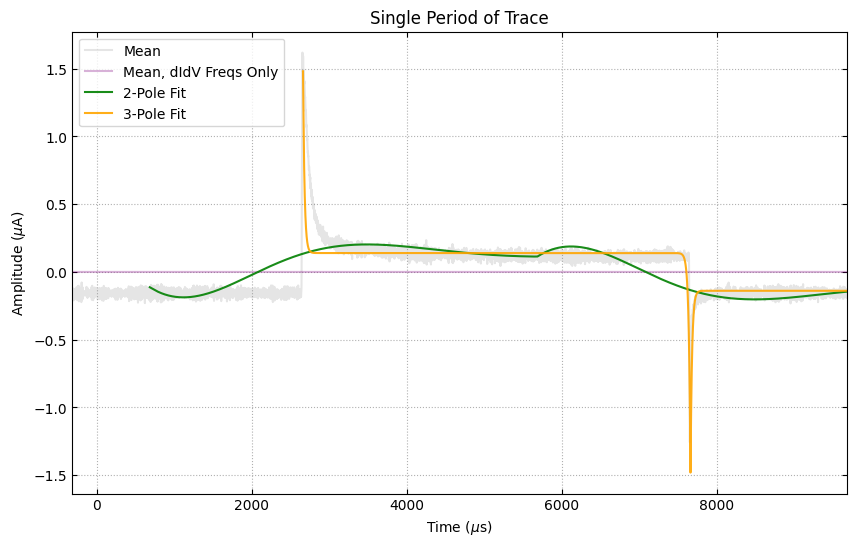

In [356]:
# display
for c in channels_quick:
    print('channel '+ c)
    didvfit[c].plot_single_period_of_trace(didv_freq_filt=True)
    #didvfit[c].plot_re_im_didv()

In [ ]:
# "required params" ['rp', 'i0', 'i0_err','r0', 'r0_err']

In [199]:
ivfits.rp[0]
#didv.config['offA']

array([ 0.05457594,  0.00337708, -0.0058354 ])

In [200]:
# dict used to calculate small signal params
for i, c in enumerate(channels):
    """
    ivsweep_results_fromdemo = {
        'close_loop_norm': 10*1.2e3*2, # idk (see above)
        'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
        'i0': didv.config['off'+c]/1e6, # ?? from Irwin chapter the "steady state" current given as I0 (A) (maybe ites?)
        # maybe baseline current outside of square wave amplitude?
        'i0_err': 0.,#8.342312444985714e-12,
        'i0_off': 0.,#3.89669341000469e-09, # ioff from DIDV? - the current offset (A)
        'i0_off_err': 0.,#5.507092047349402e-12,
        'i0_variable_offset': 0., #-9.865689873695374e-06, # ??
        'ibias': didv.config['off'+c]/1e6, # applied QET bias current (A) (ibias)
        'ibias_off': 0.,#-3.381406772500224e-08, # current offset of the QET bias (A)
        'ibias_off_err': 0.,#1.0347074588426951e-11,
        'lgc_invert_offset': True, 
        'output_variable_gain': 50.0, # see above
        'output_variable_offset': 0,#-0.12332112342119217, # see above
        'p0': 3.2911e-15, # power of TES (W)? (from bulk_tes_noise.ipynb)
        'p0_err': 5e-17,
        'r0': R_ops[i], # TES resistance (Ohms)?
        'r0_err': ivfits.rnorm_err[0,i], #0.003534606260879604,
        'rn': ivfits.rnorm[0,i], # normal-state resistance (Ohms) ?
        'rn_err': ivfits.rnorm_err[0,i], 
        'rp': ivfits.rp[0,i], # parasitic resistance in non-shunt side of TES circuit (see above) (Ohms)
        'rp_err': ivfits.rp_err[0,i],
        'rshunt': ibis.config['rsh'], # shunt resistance (Ohms)
        'rshunt_err': ibis.config['rsh']/100
        }"""

    ivsweep_results = {
        'rp': didvfit[c]._rp, #max((ivfits.rp[0,i], 0)), 
        'i0': didv.config['off'+c]/1e6, 
        'i0_err': didv.config['off'+c]/1e8,
        'r0': R_ops[i], 
        'r0_err': R_ops[i]/100
    }


    didvfit[c].calc_smallsignal_params(ivsweep_results)

INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 
INFO: Calculating small signal parameters for 2-poles model 
INFO: Calculating small signal parameters for 3-poles model 


In [201]:
didvfit['B'].fitresult(3).keys()

dict_keys(['lgcfix', 'params_array', 'params', 'cov', 'errors', 'falltimes', 'cost', 'offset', 'offset_err', 'biasparams', 'smallsignalparams', 'ssp_light', 'didv0', 'dpdi0', 'dpdi0_err'])

In [202]:
for c in channels:
        # printing out results
        results = didvfit[c].fitresult()
        data = {'Model':['2-pole', '3-pole'],
                'Tau1 [usec]': ['{:.3g}'.format(1e6*np.abs(results[2]['params']['tau1'])),
                                '{:.3g}'.format(1e6*np.abs(results[3]['params']['tau1']))],
                'Tau2 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau2']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau2'])],
                'Tau3 [usec]': ['{:.3g}'.format(1e6*results[2]['params']['tau3']),
                                '{:.3g}'.format(1e6*results[3]['params']['tau3'])]}
                
                
        
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('Fit time constants, NOT dIdV Poles: ')
        print(df.to_string(index = False))
                
        data = {'Model':['2-pole', '3-pole'],
                'Tau+[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][0]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][0])],
                'Tau-[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][1]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][1])],
                'Tau3[usec]': ['{:.3g}'.format(1e6*results[2]['falltimes'][2]),
                        '{:.3g}'.format(1e6*results[3]['falltimes'][2])]}
        # Create a DataFrame
        df = pd.DataFrame(data)

        # Display the DataFrame
        print('\nTrue dIdV Poles: ')
        print(df.to_string(index = False))

        print('\n============\n')

Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole       0.217    4.52e-25           0
3-pole       0.319    3.78e-05    4.99e+05

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole   4.52e-25       38.7          0
3-pole   2.26e-05       38.8   4.99e+05


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole        20.2        11.1           0
3-pole        36.7        11.1    9.07e-06

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       3.49       3.49          0
3-pole   9.03e-06       3.48       3.49


Fit time constants, NOT dIdV Poles: 
 Model Tau1 [usec] Tau2 [usec] Tau3 [usec]
2-pole    2.91e+07        65.7           0
3-pole          21         722     1.7e+05

True dIdV Poles: 
 Model Tau+[usec] Tau-[usec] Tau3[usec]
2-pole       65.7   2.91e+07          0
3-pole       33.6       52.3    1.7e+05




In [203]:
R_ops

array([0.00884133, 0.04019908, 0.03331875])

In [204]:
didvfit['C'].fitresult(3)['smallsignalparams']

{'rsh': 0.02,
 'rp': np.float64(0.003377084720486489),
 'r0': np.float64(0.040199078554883354),
 'beta': np.float64(21.819016895143506),
 'l': np.float64(1.3212829705070401),
 'L': np.float64(1.043415783098662e-05),
 'tau0': np.float64(1.1783174426213304e-05),
 'gratio': np.float64(0.26212247035215475),
 'tau3': np.float64(9.072612612049892e-12),
 'dt': np.float64(0.0029306516152235213)}

In [205]:
signalparams = pd.DataFrame.from_dict({param: [didvfit[c].fitresult(3)['smallsignalparams'][param] for c in channels] for param in ['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt']})
signalparams.index = list(channels)
signalparams.T

,B,C,D
rsh,2.000000e-02,2.000000e-02,2.000000e-02
rp,5.457594e-02,3.377085e-03,-5.835402e-03
r0,8.841325e-03,4.019908e-02,3.331875e-02
beta,7.557929e+03,2.181902e+01,5.201893e-01
l,1.096108e+02,1.321283e+00,8.552958e-01
L,2.529350e-09,1.043416e-05,4.680959e-05
tau0,3.462680e-05,1.178317e-05,3.044487e-06
gratio,1.209902e-26,2.621225e-01,9.573757e-31
tau3,4.993749e-01,9.072613e-12,1.698201e-01
dt,2.968767e-03,2.930652e-03,3.091671e-03


In [206]:
# calculate and plot dPdIs
if 0:
    for chan in channels:
        qp.get_dPdI_with_uncertainties(len(didv.ts)*didv.ts/4/(didv.ts[-1]-didv.ts[0])**2, didvfit[chan].fitresult()[3], lgcplot=True)

In [210]:
# save results
if 1:
    savefile = folder_base + f'/Run{runnum}/dIdV Data/{runname}_results.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = {c: didvfit[c].fitresult() for c in channels})
    print('saved data to', savefile)

saved data to C:/Users/MINER/Documents/B13 Cryolab/Run5/dIdV Data/20250605-0003_results.dat


In [208]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offB': -189.0,
 'offC': -129.4,
 'offD': -89.4}

Text(0, 0.5, 'amplitude (uA)')

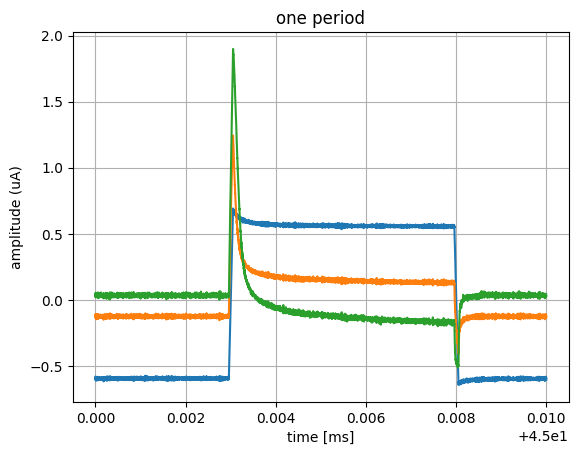

In [211]:
# trying to get impedance data directly

#Vb = pico_to_ibias(didv('H')[0,:10_000])*didv.config['rsh']*didv.conv['H'] 
Ib = pico_to_ibias(didv('H')[:10_000]) # amps through bias line
ts = didv.ts[:10_000] + 45e-3 #å s

plt.figure()

traces = {}
Vb = {}


for c in channels:

    Vb[c] = didv.config['rsh']*(Ib + abs(didv.config['off' + c])/1e6)

    avg = didv(c).mean(axis=0) 

    #traces[c] = avg.reshape((10, 10_000)).mean(axis = 0) # amps
    #traces[c] = avg[:10_000]
    #traces[c] = didv(c)[0].reshape((10, 10_000)).mean(axis = 0)
    traces[c] = didv(c)[:10_000_000].reshape((-1, 10_000)).mean(axis = 0)

    plt.plot(ts*1e3, traces[c]*1e6)

#plt.plot(ts*1e3, Ib*1e6)

plt.grid()
plt.title('one period')
plt.xlabel('time [ms]')
plt.ylabel('amplitude (uA)')

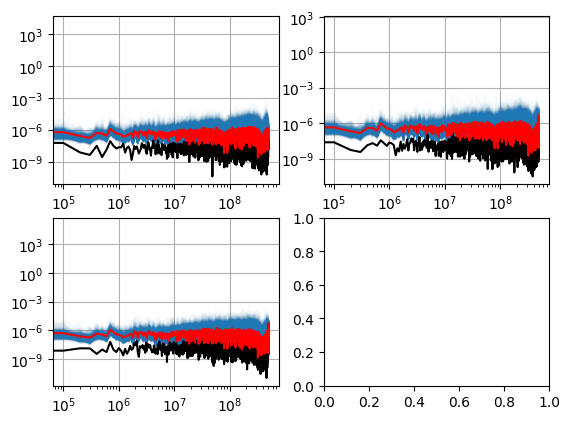

In [213]:
# frequency space

N = len(ts)
T = (ts[-1] - ts[0])/2

idx, tk, wn = of.get_idx_tk_wn(N, T)

fn = wn/2/np.pi

Vn = {}

Zn = {}

fig, axs = plt.subplots(2, 2)

for ax, c in zip(axs.flatten(), channels):

    Vn[c] = of.fft(Vb[c])

    #all_traces = didv(c).reshape((-1, 10_000))
    all_traces = didv(c)[:10_000_000].reshape((-1, 10_000))

    In = of.fft(all_traces, axis = -1)*all_traces.shape[0]
    Zn[c] = (Vn[c]/In).mean(axis = 0)

    ax.loglog()

    for Z in (Vn[c]/In):
        ax.plot(fn, abs(Z), alpha = 0.02, color = 'C0')

    ax.plot(fn, abs(Zn[c]), color = 'k')
    ax.plot(fn, (abs(Vn[c]/In)).mean(axis = 0), 'r')

    ax.grid()


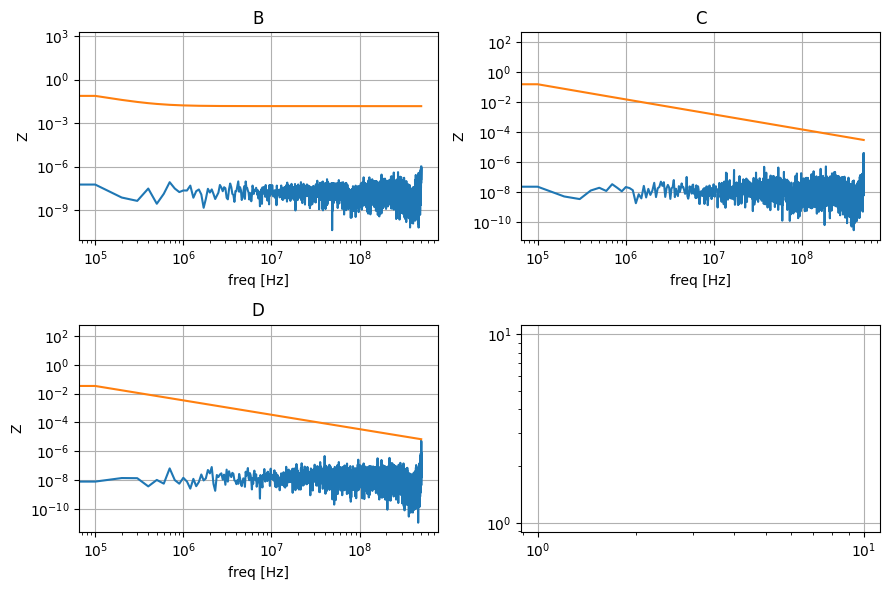

In [214]:
# impedance plot

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
for ax in axs.flatten():
    ax.loglog()
    ax.grid()

for c, ax in zip(channels, axs.flatten()):

    ax.plot(fn, abs(Zn[c]))

    fit_params_dict = didvfit[c].fitresult(3)['params']

    A = fit_params_dict['A']
    B = fit_params_dict['B']
    C = fit_params_dict['C']
    tau1 = fit_params_dict['tau1']
    tau2 = fit_params_dict['tau2']
    tau3 = fit_params_dict['tau3']
    dt = fit_params_dict['dt'] 

    Zref = 1/abs(A*(1+1j*wn*tau2) + B/(1 + 1j*wn*tau1 - C/(1 + 1j*wn*tau3)))

    ax.plot(fn, Zref)
    ax.set_title(c)
    ax.set_xlabel('freq [Hz]')
    ax.set_ylabel('Z')

fig.tight_layout()

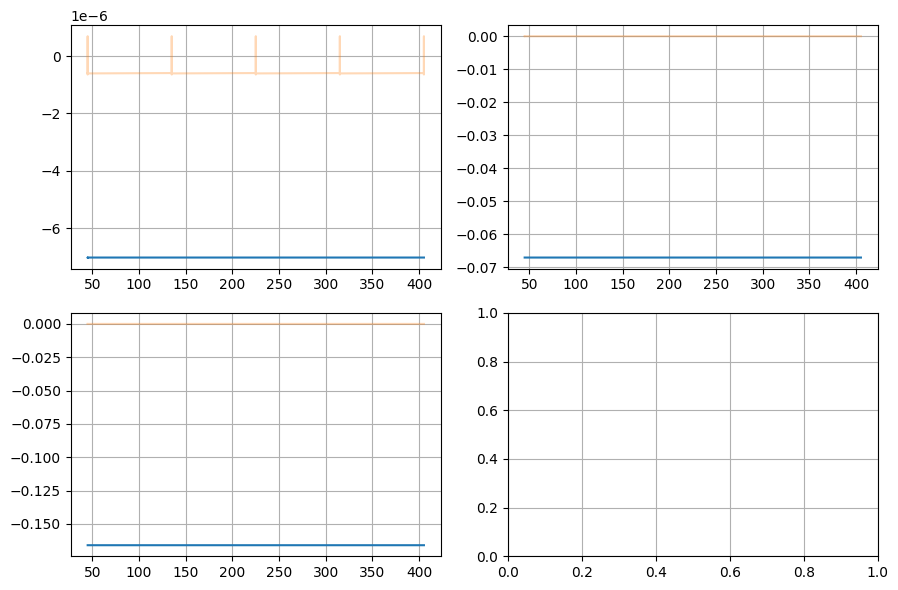

In [215]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6))
for ax in axs.flatten():
    #ax.loglog()
    ax.grid()

for c, ax in zip(channels, axs.flatten()):

    #ax.plot(ts*1e3, traces[c])

    fit_params_dict = didvfit[c].fitresult(3)['params']

    A = fit_params_dict['A']
    B = fit_params_dict['B']
    C = fit_params_dict['C']
    tau1 = fit_params_dict['tau1']
    tau2 = fit_params_dict['tau2']
    tau3 = fit_params_dict['tau3']
    dt = fit_params_dict['dt'] 

    dVdIref = A*(1 + 1j*wn*tau2) + B/(1 + 1j*wn*tau1 - C/(1 + 1j*wn*tau3))

    I0n = (Vn[c])*dVdIref

    I0 = of.ifft(I0n*np.exp(1j*wn*dt)) #+ abs(didv.config['off'+c]/1e6)

    t5 = np.hstack([(2*i*ts[-1]+ts)*1e3 for i in range(5)])

    ax.plot(t5, np.hstack(5*[np.roll(np.real(I0), len(I0)//2)]))
    ax.plot(t5, np.hstack(5*[traces[c]]), alpha = 0.3)

fig.tight_layout()

In [216]:
didv.config

{'amp': 0.02,
 'freq': 100.0,
 'rsh': 0.02,
 'gain': 50.0,
 'offB': -189.0,
 'offC': -129.4,
 'offD': -89.4}

In [218]:
didvfit['C'].fitresult(3)['smallsignalparams'].keys()

dict_keys(['rsh', 'rp', 'r0', 'beta', 'l', 'L', 'tau0', 'gratio', 'tau3', 'dt'])

In [219]:
for c in channels:
    print(c, traces[c].mean()*1e6, tr_fits[c]['I0'])

B -0.014682895724595427 -192.4
C 0.027349686634036807 -128.4
D -0.008610190046345105 -89.4


In [220]:
tr_fits[c]['R_op']

np.float64(0.033318750314959934)

In [221]:
R_ops

array([0.00884133, 0.04019908, 0.03331875])

0.05457594026167126 0.02
0.003377084720486489 0.02
-0.0058354022001815935 0.02


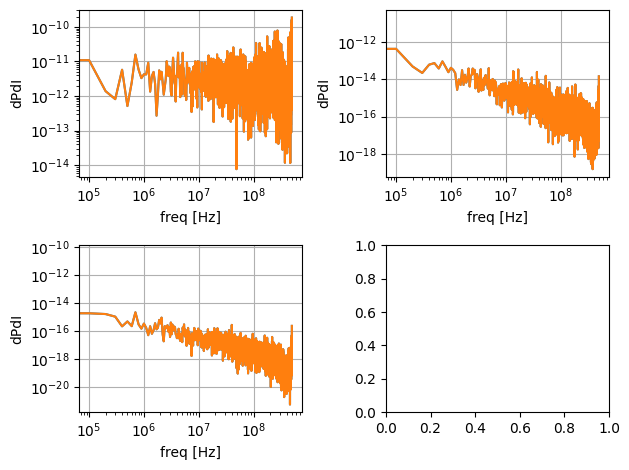

In [223]:
dpdi_num = {}

fig, axs = plt.subplots(2, 2)


for ax, c in zip(axs.flatten(), channels):

    #all_traces = didv(c).reshape((-1, 10_000))
    
    all_traces = didv(c)[:10_000_000].reshape((-1, 10_000))
    In = of.fft(all_traces, axis = -1)*all_traces.shape[0]
    Z = Vn[c]/In

    param_dict = didvfit[c].fitresult(3)['smallsignalparams']

    rsh = param_dict['rsh']
    rp = param_dict['rp']
    r0 = param_dict['r0']
    beta = param_dict['beta']
    l = param_dict['l']
    L = param_dict['L']
    tau0 = param_dict['tau0']
    gratio = param_dict['gratio']
    tau3 = param_dict['tau3']
    dt = param_dict['dt']

    print(rp, rsh)

    dpdi = abs((tr_fits[c]['I0']*1e-6)*r0)*(2 + beta)*Z/(Z - (1j*wn*L + rsh + rp + r0*(1+beta)))

    dpdi2 = abs((tr_fits[c]['I0']*1e-6)*r0)*(2 + beta)*Zn[c]/(Zn[c] - (1j*wn*L + rsh + rp + r0*(1+beta)))

    ax.loglog(fn[N//2:], abs(dpdi2)[N//2:])
    ax.loglog(fn[N//2:], abs(dpdi.mean(axis = 0))[N//2:])

    dpdi_num[c] = dpdi.mean(axis = 0)
    #dpdi_num[c] = dpdi2

    ax.set_xlabel('freq [Hz]')
    ax.set_ylabel('dPdI')
    ax.grid()

fig.tight_layout()
dpdi_num['freq'] = fn

In [224]:
for c in channels:
    print(c, didv(c).reshape((-1, 10_000)).shape)

ValueError: cannot reshape array of size 10000004 into shape (10000)

In [225]:
# save numerical dpdi
if 1:
    savefile = folder_base + f'/Run{runnum}/dIdV Data/{runname}_numerical_dpdi.dat'
    with open(savefile, 'wb') as f:
        pickle.dump(file = f, obj = dpdi_num)
    print('saved data to', savefile)

saved data to C:/Users/MINER/Documents/B13 Cryolab/Run5/dIdV Data/20250605-0003_numerical_dpdi.dat


In [ ]:
fn

array([-500050.0065008, -499949.9964995, -499849.9864982, ...,
        499749.9764969,  499849.9864982,  499949.9964995], shape=(10000,))

In [ ]:
for c in channels:
    print(didvfit[c].fitresult(3)['smallsignalparams']['rp'])

0.07822705157001561
0.06310075746068242
0.002977813302007984
0.005101919590268619
